# GridSearchCV + KFold CV: The Right Way

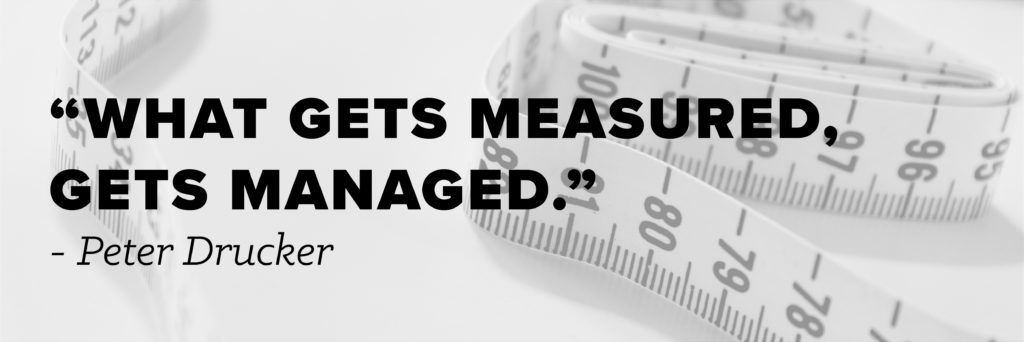

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")

# Table of Contents

<a id="toc"></a>
- [1. Building the best possible model](#1)
    - [1.1 Train-test split is not enough](#1.1)
    - [1.2 Does cross-validation replace train-test split?](#1.2)
    - [1.3 Workflow - the right way](#1.3)
- [2. Set-up](#2)
    - [2.1 Import Libraries](#2.1)
    - [2.2 Import Data](#2.2)
    - [2.3 Data Set Characteristics](#2.3)
    - [2.4 Dataset Attributes](#2.4)
- [3. Data pre-processing](#3)
    - [3.1 Data imbalance check](#3.1)
    - [3.2 Checking for outliers](#3.2)
    - [3.3 Inter Quartile Range (IQR)](#3.3)
    - [3.4 Dropping outliers](#3.4)
    - [3.5 Creating dummies](#3.5)
    - [3.6 Train test split](#3.6)
    - [3.7 Feature scaling](#3.7)
- [4. Model building](#4)
    - [4.1 Optimising for Recall, Precision or Accuracy?](#4.1)
    - [4.2 K-Fold Cross-validation](#4.2)
    - [4.3 Hyperparameter Tuning Using GridSearchCV](#4.3)
    - [4.4 K-Fold Cross-validation after tuning hyperparameters](#4.4)
    - [4.5 Result comparison](#4.5)
    - [4.6 AUC-ROC Curve](#4.6)
    - [4.7 Precision-Recall Curve (PR curve)](#4.7)
- [5. My other notebooks](#5)

<a id="1"></a>
# 1. Building the best possible model 

Machine learning process involves selecting the model with best performance. However that is not always an easy task. The best model is not the one that gives accurate predictions on the training data, but the one which gives good predictions on the new data and avoids overfitting and underfitting.

We have two important factors to cover here:

1. The performance on cross validation set. 
2. The choice of hyperparameters.

Quite often, we can see cross validation used improperly, or the result of cross validation not being interpreted correctly.

We have very important questions here:
1. Does cross-validation replace train-test split?
2. Do we still need to take advantage of K-fold CV while performing GridSearchCV?
3. What is the correct workflow for K-fold CV with GridsearchCV?

<a id="1.1"></a>
## 1.1 Train-test split is not enough 

We need to be sure that we have choosen the best possible hyperparameters and that we have trained our model the most robust way.

When we split the data into one set of training data and one set of validation data, the performance metrics are highly dependent on those sets. We train and evaluate our model only once so the performance depends on that evaluation. Thus our model may perform very differently when trained and evaluated on different subsets of the same data. Sometimes we might get a high score because we’re lucky to have an appropriate training set, other times the score might be low since we run out of luck. 

Anyway - training our modles with only one time train-test procedure will produce most likely a random (in a certain way) result. If we have more models, and found that one model is better than another based on the evaluation, how can we know this is also not by chance?

<a id="1.2"></a>
## 1.2 Does cross-validation replace train-test split?

What we should always care about is the evaluation metric on the unseen data. Why? Because it's always about unseen data. We build our model to evaluate future data, so it's a good idea to simulate this situation in the model-building process.

Therefore, we need to keep a part of data and save it for the final evaluation. This data will be a “final exam” for our model and the exam questions must not be seen before. Final evaluation score shouldn't be very different from that we obtained from cross validation if we did the model training correctly. This can serve as a confirmation for our model selection.

**Anyway We should still perform train-test split before cross-validation**.

<a id="1.3"></a>
## 1.3 Workflow - the right way

1. Train-test split.
2. Perform K-fold CV ONLY on the training set (that will allow us to compare results).
3. Perform GridSearchCV ONLY on the training set.
4. Perform K-fold CV using hyperparameters obtained from GridSearchCV procedure ONLY on the training set and compare results.
5. Evaluate the model’s final performance on test set.

<a id="2"></a>
# 2. Set-up

<a id="2.1"></a>
## 2.1 Import Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from collections import Counter

<a id="2.2"></a>
## 2.2 Import Data

In [3]:
try:
    raw_df = pd.read_csv('../input/heart-failure-prediction/heart.csv')
except:
    raw_df = pd.read_csv('heart.csv')

<a id="2.3"></a>
## 2.3 Data Set Characteristics

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Four out of 5CVD deaths are due to heart attacks and strokes, and one-third of these deaths occur prematurely in people under 70 years of age. Heart failure is a common event caused by CVDs and this dataset contains 11 features that can be used to predict a possible heart disease.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

**There are no duplicates and no missing values in dataset**.

https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

<a id="2.4"></a>
## 2.4 Dataset Attributes
    
- **Age** : age of the patient [years]
- **Sex** : sex of the patient [M: Male, F: Female]
- **ChestPainType** : chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- **RestingBP** : resting blood pressure [mm Hg]
- **Cholesterol** : serum cholesterol [mm/dl]
- **FastingBS** : fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- **RestingECG** : resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- **MaxHR** : maximum heart rate achieved [Numeric value between 60 and 202]
- **ExerciseAngina** : exercise-induced angina [Y: Yes, N: No]
- **Oldpeak** : oldpeak = ST [Numeric value measured in depression]
- **ST_Slope** : the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- **HeartDisease** : output class [1: heart disease, 0: Normal]

In [4]:
raw_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


<a id="3"></a>
# 3. Data pre-processing

<a id="3.1"></a>
## 3.1 Data imbalance check

In [5]:
labels=["Healthy","Heart Disease"]

healthy_or_not = raw_df['HeartDisease'].value_counts().tolist()
values = [healthy_or_not[0], healthy_or_not[1]]

fig = px.pie(values=raw_df['HeartDisease'].value_counts(), names=labels , width=700, height=400, color_discrete_sequence=["skyblue","black"]
             ,title="Healthy vs Heart Disease")
fig.show()

We can see that the data is quite well balanced so we don't need to take advantage of undersampling or oversampling techniques.

<a id="3.2"></a>
## 3.2 Checking for outliers

In [6]:
numerical_columns = list(raw_df.loc[:,['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']])
categorical_columns = list(raw_df.loc[:,['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']])

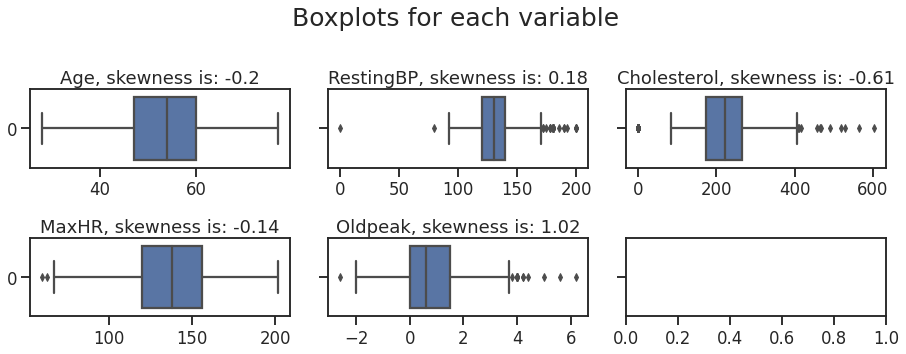

In [7]:
# checking boxplots
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(13,5))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))
        
boxplots_custom(dataset=raw_df, columns_list=numerical_columns, rows=2, cols=3, suptitle='Boxplots for each variable')
plt.tight_layout()

<a id="3.3"></a>
## 3.3 Inter Quartile Range (IQR)

Tukey’s (1977) technique is used to detect outliers in skewed or non bell-shaped data since it makes no distributional assumptions. However, Tukey’s method may not be appropriate for a small sample size. The general rule is that anything not in the range of (Q1 - 1.5 IQR) and (Q3 + 1.5 IQR) is an outlier, and can be removed.

Inter Quartile Range (IQR) is one of the most extensively used procedure for outlier detection and removal.

Procedure:

1. Find the first quartile, Q1.
2. Find the third quartile, Q3.
3. Calculate the IQR. IQR = Q3-Q1.
4. Define the normal data range with lower limit as Q1–1.5 IQR and upper limit as Q3+1.5 IQR.

For oulier detection methods look here: https://www.kaggle.com/code/marcinrutecki/outlier-detection-methods

In [8]:
def IQR_method (df,n,features):
    """
    Takes a dataframe and returns an index list corresponding to the observations 
    containing more than n outliers according to the Tukey IQR method.
    """
    outlier_list = []
    
    for column in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        # appending the list of outliers 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of records below and above lower and above bound value respectively
    out1 = df[df[column] < Q1 - outlier_step]
    out2 = df[df[column] > Q3 + outlier_step]
    
    print('Total number of deleted outliers is:', out1.shape[0]+out2.shape[0])
    
    return multiple_outliers

<a id="3.4"></a>
## 3.4 Dropping outliers

In [9]:
# detecting outliers
Outliers_IQR = IQR_method(raw_df,1,numerical_columns)

# dropping outliers
df = raw_df.drop(Outliers_IQR, axis = 0).reset_index(drop=True)

Total number of deleted outliers is: 16


<a id="3.5"></a>
## 3.5 Creating dummies

In [10]:
df = pd.get_dummies(df, drop_first=True)

<a id="3.6"></a>
## 3.6 Train test split

In [11]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 42)

<a id="3.7"></a>
## 3.7 Feature scaling

In [13]:
from sklearn.preprocessing import StandardScaler

# Creating function for scaling
def Standard_Scaler (df, col_names):
    features = df[col_names]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    df[col_names] = features
    
    return df

In [14]:
col_names = numerical_columns
X_train = Standard_Scaler (X_train, col_names)
X_test = Standard_Scaler (X_test, col_names)

<a id="4"></a>
# 4. Model building

In [15]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

#We are going to ensure that we have the same splits of the data every time. 
#We can ensure this by creating a KFold object, kf, and passing cv=kf instead of the more common cv=5.

kf = KFold(n_splits=5, shuffle=False)

In [16]:
rf = RandomForestClassifier(n_estimators=50, random_state=13)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=13)

In [17]:
y_pred = rf.predict(X_test)

In [18]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
cm = confusion_matrix(y_test, y_pred)

rf_Recall = recall_score(y_test, y_pred)
rf_Precision = precision_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)
rf_accuracy = accuracy_score(y_test, y_pred)

print(cm)

[[105  17]
 [ 11 139]]


<a id="4.1"></a>
## 4.1 Optimising for Recall, Precision or Accuracy?

Recall: **The ability of a model to find all the relevant cases within a data set**. The number of true positives divided by the number of true positives plus the number of false negatives.

In most high-risk detection cases (like cancer detection), recall is a more important evaluation metric than precision.

In the case of heart failure prediction, we want to avoid false negatives as much as possible. A false negative case means that a heart failure problem is not detected, which could be very dangerous. In this use case, false positives (a healthy person with a false heart problem diagnosis) are not as important as preventing a situation when we don't detect a serious problem.

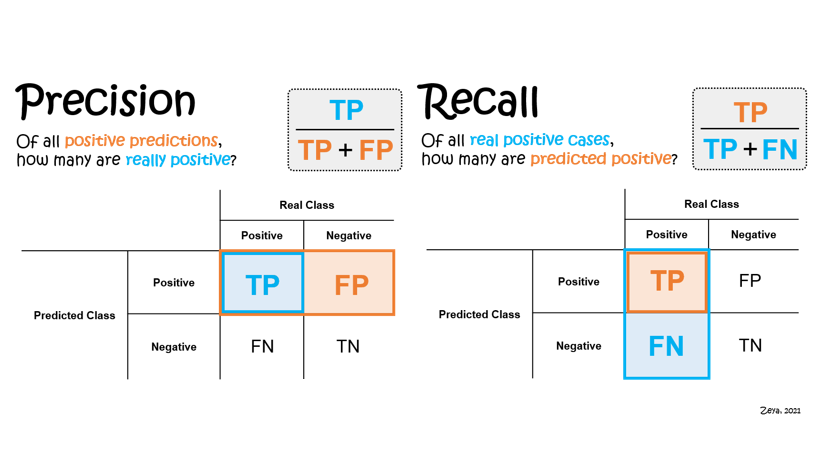

<a id="4.2"></a>
## 4.2 K-Fold Cross-validation

Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample. The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation.

The purpose of cross–validation is to test the ability of a machine learning model to predict new data.

In [19]:
from statistics import stdev
score = cross_val_score(rf, X_train, y_train, cv=kf, scoring='recall')
rf_cv_score = score.mean()
rf_cv_stdev = stdev(score)
print('Cross Validation Recall scores are: {}'.format(score))
print('Average Cross Validation Recall score: ', rf_cv_score)
print('Cross Validation Recall standard deviation: ', rf_cv_stdev)

Cross Validation Recall scores are: [0.91780822 0.80327869 0.91666667 0.92207792 0.85714286]
Average Cross Validation Recall score:  0.8833948707180236
Cross Validation Recall standard deviation:  0.05219061286859028


In [20]:
ndf = [(rf_Recall, rf_Precision, rf_f1, rf_accuracy, rf_cv_score, rf_cv_stdev)]

rf_score = pd.DataFrame(data = ndf, columns=
                        ['Recall','Precision','F1 Score', 'Accuracy', 'Avg CV Recall', 'Standard Deviation of CV Recall'])
rf_score.insert(0, 'Random Forest', 'Before tuning hyperparameters')
rf_score

,Random Forest,Recall,Precision,F1 Score,Accuracy,Avg CV Recall,Standard Deviation of CV Recall
0,Before tuning hyperparameters,0.926667,0.891026,0.908497,0.897059,0.883395,0.052191


<a id="4.3"></a>
## 4.3 Hyperparameter Tuning Using GridSearchCV

Hyperparameter tuning is the process of tuning the parameters present as the tuples while we build machine learning models. These parameters are defined by us. Machine learning algorithms never learn these parameters, but they can be tuned in different step.

GridSearchCV is essentially a cross-validation technique for finding the optimal hyperparameter values from a given set of parameters in a grid.

The “best” parameters that GridSearchCV identifies are technically the best that could be produced, **but only by the parameters that you included in your parameter grid**. Grid Search CV systematically works through multiple combinations of parameter tunes, cross validate each and determine which one gives the best performance.

Hyperparameter tuning is the process of tuning the parameters present as the tuples while we build machine learning models. These parameters are defined by us. Machine learning algorithms never learn these parameters. These can be tuned in different step.

GridSearchCV is a technique for finding the optimal hyperparameter values from a given set of parameters in a grid. It's essentially a cross-validation technique. The model as well as the parameters must be entered. After extracting the best parameter values, predictions are made.

The “best” parameters that GridSearchCV identifies are technically the best that could be produced, but only by the parameters that you included in your parameter grid.

In [21]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [130,150,170,190,200],
    'max_depth': [8,10,12,14],
    'min_samples_split': [3,4,5,6],
    'min_samples_leaf': [1,2,3],
    'random_state': [13]
}

grid_rf = GridSearchCV(rf, param_grid=params, cv=kf, 
                          scoring='recall').fit(X_train, y_train)

In [22]:
print('Best parameters:', grid_rf.best_params_)
print('Best score:', grid_rf.best_score_)

Best parameters: {'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 190, 'random_state': 13}
Best score: 0.9143824825522557


In [23]:
y_pred = grid_rf.predict(X_test)

In [24]:
cm = confusion_matrix(y_test, y_pred)

grid_rf_Recall = recall_score(y_test, y_pred)
grid_rf_Precision = precision_score(y_test, y_pred)
grid_rf_f1 = f1_score(y_test, y_pred)
grid_rf_accuracy = accuracy_score(y_test, y_pred)

print(cm)

[[104  18]
 [ 12 138]]


<a id="4.4"></a>
## 4.4 K-Fold Cross-validation after tuning hyperparameters

In [25]:
score2 = cross_val_score(grid_rf, X_train, y_train, cv=kf, scoring='recall')

In [26]:
grid_cv_score = score2.mean()
grid_cv_stdev = stdev(score2)

print('Cross Validation Recall scores are: {}'.format(score2))
print('Average Cross Validation Recall score: ', grid_cv_score)
print('Cross Validation Recall standard deviation: ', grid_cv_stdev)

Cross Validation Recall scores are: [0.93150685 0.81967213 0.9        0.92207792 0.90909091]
Average Cross Validation Recall score:  0.8964695623262882
Cross Validation Recall standard deviation:  0.04458981775214615


In [27]:
ndf2 = [(grid_rf_Recall, grid_rf_Precision, grid_rf_f1, grid_rf_accuracy, grid_cv_score, grid_cv_stdev)]

grid_score = pd.DataFrame(data = ndf2, columns=
                        ['Recall','Precision','F1 Score', 'Accuracy', 'Avg CV Recall', 'Standard Deviation of CV Recall'])
grid_score.insert(0, 'Random Forest', 'After tuning hyperparameters')
grid_score

,Random Forest,Recall,Precision,F1 Score,Accuracy,Avg CV Recall,Standard Deviation of CV Recall
0,After tuning hyperparameters,0.92,0.884615,0.901961,0.889706,0.89647,0.04459


<a id="4.5"></a>
## 4.5 Result comparison

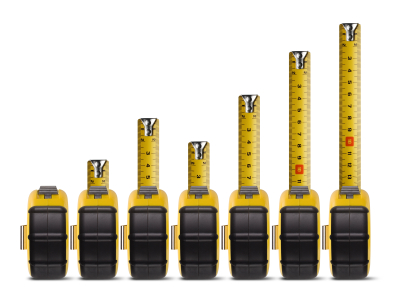

In [28]:
predictions = pd.concat([rf_score, grid_score], ignore_index=True, sort=False)
predictions.sort_values(by=['Avg CV Recall'], ascending=False)

,Random Forest,Recall,Precision,F1 Score,Accuracy,Avg CV Recall,Standard Deviation of CV Recall
1,After tuning hyperparameters,0.920000,0.884615,0.901961,0.889706,0.896470,0.044590
0,Before tuning hyperparameters,0.926667,0.891026,0.908497,0.897059,0.883395,0.052191


What happened after tuning hyper parameters:

1. We have a little bit lower Recall, but that is just because of luck (it's very normal).
2. We have improved our average cross validated Recall (Avg CV Recall).
3. We have improved standard deviation of cross validated Recall (Standard Deviation of CV Recall)
4. We traded a little bit of Accuracy and Precision to improve Recall (that it highly anticipated).

### Is our model ready for production?

Personally I would try to go through the entire procedure with different algorithms and compare results. Average Cross Validated Recall around 90% is probably not enough in this case.

<a id="4.6"></a>
## 4.6 AUC-ROC Curve

AUC (Area Under The Curve) ROC (Receiver Operating Characteristics) curve.

ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1.

The ROC curve is plotted with TPR against the FPR where TPR is on the y-axis and FPR is on the x-axis.

An excellent model has AUC near to the 1 which means it has a good measure of separability. A poor model has an AUC near 0 which means it has the worst measure of separability.

When AUC is 0.7, it means there is a 70% chance that the model will be able to distinguish between positive class and negative class.
When AUC is approximately 0.5, the model has no discrimination capacity to distinguish between positive class and negative class.
When AUC is approximately 0, the model is predicting a negative class as a positive class and vice versa.

In [29]:
from sklearn.metrics import roc_auc_score
ROCAUCscore = roc_auc_score(y_test, y_pred)
print(f"AUC-ROC Curve for Random Forest with tuned hyperparameters: {ROCAUCscore:.4f}")

AUC-ROC Curve for Random Forest with tuned hyperparameters: 0.8862


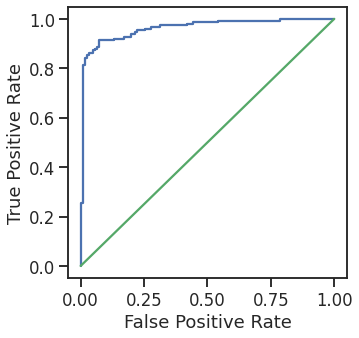

In [30]:
y_proba = grid_rf.predict_proba(X_test)

from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
def plot_auc_roc_curve(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')
# Plots the ROC curve using the sklearn methods - Good plot
plot_auc_roc_curve(y_test, y_proba[:, 1])
# Plots the ROC curve using the sklearn methods - Bad plot
#plot_sklearn_roc_curve(y_test, y_pred)

<a id="4.7"></a>
## 4.7 Precision-Recall Curve (PR curve)

The precision-recall curve shows the tradeoff between precision and recalls for different thresholds.

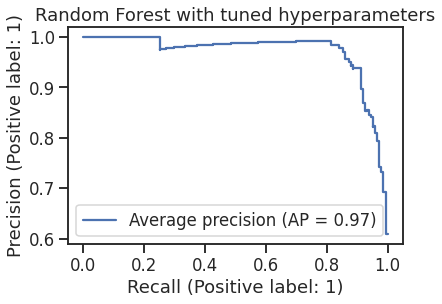

In [31]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    grid_rf, X_test, y_test, name="Average precision")
_ = display.ax_.set_title("Random Forest with tuned hyperparameters")

We can clearly see the point where we have to start trading a lot of Precision for better Recall score!

Average precision (AP) summarizes such a plot as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold.